# Validation of DT Simulation Data with Real Data

Vorgehen:
 Eventlog zeitlich aufsteigen sortieren
 Train,validation und test set bestimmen und mit 1 labeln
 Aufträge aus den Daten generieren Order darf nicht die gesamten Prozessschritte beinhalten Features requested auslesen automatisch => Wie bei Schmaus? Was ist relevantes Features und was sind unwichtige Prozessdaten? TransformationModell soll Feautures entrhalten nur ORders = Aufträge mit sinnvollen Features: Finde sinnvolle Aufträge
Wahrtscheinlich passen die Zeiten aber die exakten Zeitpunkte was mit denen?


Ich konsultiere processed_data.csv um anhand der Case ID einige gesunde Trajektorien herauszufindne und notiere mir das Datum.

Ich muss bestimmte Prozessschritte rausfiltern die nicht zum TransformationModel gehören. 

Gute Trajektorien:

20.04.2022 bis einschl. 22.04.2022
02.05.2022 bis einschl. 19.07.2022
02.11.2022
11.11.2022, 23.11.2022
März 2023 komplett

Maßgeblich für die Mappings sind die Mapping Files aus der Simulation!

Peeking vermeiden: Process Execution ID und Feature Enginnering Variable time since last process ermöglichen peeking! 

a- allgemeine Regeln festlegen
- Process Mining kann Schwellenwert festlegen

- was machen wir mit den kaputten Orders?
- Industriedaten sind eher sauberer als IoT Daten
- Simulation soll Standardablauf im Best Case abbilden => was in State x am wahrscheinlichsten ist auch ausnahmefälle sollten abgebildet werden
- Z.B. Teil ist nicht da => Dauer höher, deswegen Ausnahmefälle mit in Validierung rein
- Trainingsdaten sollten nicht kaputte Orders enthalten also Wartungsläufe sollten nicht drin sein
- Clustering => Outliers rausfiltern
- Ist Häufigkeit überhaupt ein wichtiges Kriterium? Ist dies als Referenzwert 
- Datenübertragungsfehler oder NA Values wie geht man damit um? 
- Wartezeiten Starttime t - Endtime t-1 Feature rein machen
- Erstellt man daraus einen Prozess? Welche Wartezeiten gibt es? Transportbedingt? Diese kann man mit Verteilung schätzen. Idle Times verteilung auch ?

1. Prozesse die nicht im Ablauf vorkommen raus z.B. Testanläufe => in Manuelles Arbeitskonto 
2. Fehjlerhafte Daten korrigieren automatisch ausgleichen z.B. Negative Duration als Schritt bei Bedarf zt.B. correction_utils
3. Übrige Fehelrhafte daten als Gesamtdaten raus
4. Rest muss drinbleiben raus

Lernen mit Standarddaten ohne Filterung
Validierung mit Sonderdaten 

Training, Validierung und Testset für DT erstellen und dann Classifier trainieren
Validierungsdatensatz: Orders mit ID aus Echten Welt und simuliert mit gleichen Ids und Inhalt und featuren aus Simulation
Zeitpunkte alignment in der SImulation!! BEstellzeitraum anpassen => Manueller Aufwand messen Zeit des Experten
Test: Finale Validierung des Modelles für die Vorhersagequalität

Im echten Leben wäre der Testdatensatz Onlinedaten mit Alert um Validierung

Zeitlich zusammenhängende Blöcke validieren Was ist eine Pause für uns was ist relevant? Bleibt maschine stehen oder so? Availability der Resourcen nicht gegeben. Im echten Leben muss man Pausen modellieren idle

@Roman schreiben wie ist es aktuell mit der Factory?

Validieren ob Order komplett fertig gemacht wird oder schon parallel weiteres Teil gefertigt wird

Wo finden pausen statt? Plot => Transport lässt sich erklären oder auch zwischen Orders 

Prozesszeit mit ausrechnen

ERST: SIM DATEN MIT REALEN DATEN VERGLEICHEN BEVOR ICH ML MACHE

Christian:

1.	Prozesse, die nicht im Betrieb der Fabrik vorkommen werden entfernen (Wartung, Test, Anlauf)
2.	Fehlerhafte Daten korrigieren (Falsche IDs, Überlappende Timestamps, usw.)
3.	Übrige Fehlerhafte Datensätze (ganze Aufträge) entfernen
4.	Übrige Sonderfälle müssen drinbleiben
5.	Training, Validation und Test Set
6.	Mit Trainingsdaten wird der DT erstellt (Pausenthema im Hinterkopf halten, für die IOT Factory u.U. manuell entfernen)
7.	Validierungsdatensatz in zeitlich zusammenhängende Blöcke ohne Pausen):
a.	Aufträge (mit Id) aus Realer Fabrik
b.	Aufträge(mit gleiche ID und Features) aus Simulation (Startzeit = erster Echtauftrag)
	Manuellen Aufwand messen
8.	Finale Validierung: Testdatensatz: Vorhersagequalität):
a.	Aufträge (mit Id) aus Realer Fabrik
b.	Aufträge(mit gleiche ID und Features) aus Simulation (Startzeit = erster Echtauftrag)




## Utils

In [58]:
# TIME CONVERSION UTILITY

import math
from typing import Tuple


def sin_cos_to_weekday(sin_val: float, cos_val: float) -> Tuple[int, str]:
    """
    Given the sine and cosine values computed as:
      sin_val = sin(2*pi*weekday/7)
      cos_val = cos(2*pi*weekday/7)
    this function recovers the weekday as an integer (0=Monday, ..., 6=Sunday)
    and returns the corresponding weekday name.
    """
    # Compute the angle in radians from sin and cos values
    angle = math.atan2(sin_val, cos_val)
    # Ensure angle is in [0, 2*pi)
    if angle < 0:
        angle += 2 * math.pi
    # Invert: angle = 2*pi*day/7  =>  day = angle * 7 / (2*pi)
    day = angle * 7 / (2 * math.pi)
    # Round to nearest integer to account for floating point error,
    # and use modulo 7 in case rounding gives 7.
    weekday = int(round(day)) % 7

    weekday_names = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
    return weekday, weekday_names.get(weekday, "Unknown")


def describe_sin_cos(sin_val: float, cos_val: float) -> str:
    """
    Returns a string describing the provided sin and cos values,
    along with the recovered weekday information.
    """
    weekday, weekday_name = sin_cos_to_weekday(sin_val, cos_val)
    return (
        f"sin: {sin_val:.4f}, cos: {cos_val:.4f} corresponds approximately "
        f"to weekday index {weekday} ({weekday_name})."
    )

In [59]:
import holidays
from datetime import datetime, timedelta


def is_not_weekday(date: datetime) -> bool:
    """
    Check if the given date is a non-working day (weekend or German holiday).
    """
    # Check if the date is a weekend (Saturday=5, Sunday=6)
    if date.weekday() >= 5:
        return True
    # Check if the date is a holiday in Germany
    de_holidays = holidays.Germany(years=date.year)
    return date in de_holidays


def is_break(timepoint: datetime) -> bool:
    """
    Check if the given datetime falls into a break period.
    Break periods are defined as:
      - Night break: from 17:00 (inclusive) to 08:00 (exclusive)
      - Lunch break: from 12:00 (inclusive) to 14:00 (exclusive)
    """
    hour = timepoint.hour
    in_night_break = hour >= 17 or hour < 8
    in_lunch_break = 12 <= hour < 14
    return in_night_break or in_lunch_break

In [60]:
# REPORTING UTILITY

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)


def generate_report(y_true, y_pred, y_proba):
    """
    Generates a detailed report of binary classifier performance.

    Args:
        y_true (array-like): True target labels.
        y_pred (array-like): Predicted class labels.
        y_proba (array-like): Probabilities for the positive class.
    """
    # Print classification report and key metrics
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Classification Report:")
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("ROC AUC: {:.2f}".format(auc))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f1))

    # Compute confusion matrix and ROC curve
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    # Create subplots for Confusion Matrix and ROC Curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot confusion matrix
    im = ax1.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax1.figure.colorbar(im, ax=ax1)
    ax1.set(
        xticks=np.arange(2),
        yticks=np.arange(2),
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"],
        title="Confusion Matrix",
        ylabel="True label",
        xlabel="Predicted label",
    )
    # Loop over data dimensions and add text annotations.
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(
                j,
                i,
                format(cm[i, j], "d"),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    # Plot ROC curve
    ax2.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = {:.2f})".format(auc),
    )
    ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Model")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("Receiver Operating Characteristic (ROC)")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

## Preprocessing

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load data with process_execution_id as index and proper datetime parsing.


real_data = pd.read_csv(
    r"C:\ofact-intern\projects\iot_factory\val\data\real_factorydata_oclog.csv",
    parse_dates=["start_time", "end_time"],
    index_col="process_execution_id",
)


# NOT THE SAME TIME HORIZON


sim_data = pd.read_csv(
    r"C:\ofact-intern\projects\iot_factory\val\data\simulated_data_oclog.csv",
    parse_dates=["start_time", "end_time"],
    index_col="process_execution_id",
)


# set all is valid values to 0 in sim_data


sim_data["is_valid"] = 0


sim_data["duration"] = sim_data["end_time"] - sim_data["start_time"]


sim_data["duration"] = sim_data["duration"].dt.total_seconds()

## Diskrepanzen bereinigen

### Unify Part IDs

Simulation hat weniger Part IDs als Reale Daten. Standardisiere hier:

In [62]:
def unify_and_drop_part_ids(real_data: pd.DataFrame) -> pd.DataFrame:
    # Define the main mapping (correct mapping)
    main_mapping = {
        "stopper": 0,
        "cover": 1,
        "rass1": 2,
        "analog": 3,
        "gyroscope": 4,
        "rass2": 5,
        "rass3": 6,
        "pcb": 7,
        "display": 8,
    }

    # Define the wrong mapping (current mapping in the data)
    wrong_mapping = {
        "stopper": 0,
        "robot": 1,
        "gyroscope": 2,
        "cover": 3,
        "pcb": 4,
        "display": 5,
        "analog": 6,
        "rass2": 7,
        "rass3": 8,
        "mainpcb": 9,
        "schield": 10,
        "rass1": 11,
        "frontcover": 12,
        "shield": 13,
        "weather": 14,
        "workpiece": 15,
    }

    # Create reverse mapping from wrong mapping: wrong_id -> category
    wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

    # Define a function to update the part_id for a row.
    def update_part_id(row):
        wrong_id = row["part_id"]
        # Look up category using wrong_mapping_rev. If not found, return None.
        category = wrong_mapping_rev.get(wrong_id)
        if category is None:
            return None
        # If the category is in the main mapping, return the corresponding id
        if category in main_mapping:
            return main_mapping[category]
        else:
            # Otherwise, return None to indicate the row should be dropped.
            return None

    # Create a new column with the unified part ids.
    real_data["updated_part_id"] = real_data.apply(update_part_id, axis=1)

    # Drop rows where updated_part_id is None (meaning category not in the main mapping)
    unified_data = real_data.dropna(subset=["updated_part_id"]).copy()

    # Convert updated_part_id to integer
    unified_data["updated_part_id"] = unified_data["updated_part_id"].astype(int)

    # Optionally, replace the original part_id with the unified one and drop the temporary column.
    unified_data["part_id"] = unified_data["updated_part_id"]
    unified_data = unified_data.drop(columns=["updated_part_id"])

    return unified_data


real_data = unify_and_drop_part_ids(real_data)

### Type ID unify

In [63]:
def unify_and_drop_process_types(real_data: pd.DataFrame) -> pd.DataFrame:
    # Main (correct) mapping for process_type.
    main_mapping = {"machine": 0, "feature": 1, "endproduct": 2}

    # Wrong mapping from the data.
    wrong_mapping = {
        "machine": 0,
        "endproduct": 1,
        "feature": 2,
        "transport": 3,
        "test": 4,
    }

    # Create a reverse mapping: wrong_id -> category
    wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

    # Function to update the process_type for each row.
    def update_process_type(row):
        wrong_id = row["process_type"]
        category = wrong_mapping_rev.get(wrong_id)
        if category is None or category not in main_mapping:
            # Drop row if the category is not in main mapping (i.e., transport, test)
            return None
        return main_mapping[category]

    # Create a new column with unified process_types.
    real_data["updated_process_type"] = real_data.apply(update_process_type, axis=1)

    # Drop rows without a valid unified process_type.
    unified_data = real_data.dropna(subset=["updated_process_type"]).copy()

    # Convert to integer.
    unified_data["updated_process_type"] = unified_data["updated_process_type"].astype(
        int
    )

    # Replace original process_type with the unified value.
    unified_data["process_type"] = unified_data["updated_process_type"]
    unified_data = unified_data.drop(columns=["updated_process_type"])

    return unified_data


real_data = unify_and_drop_process_types(real_data)

### Ressource ID unify

In [64]:
# Define the wrong mapping (used in real data) and create its reverse:
wrong_mapping = {
    "CP-MOBI-WORK-DOCK": 0,
    "CP-F-ASRS20-B": 1,
    "CP-F-ASRS32-P": 2,
    "CP-F-PALROB-B": 3,
    "CP-PICKSORT": 4,
    "CP-AM-CAM": 5,
    "CP-AM-iPICK": 6,
    "CP-F-RASS-1": 7,
    "CP-AM-MEASURE": 8,
    "CP-F-RASS-2": 9,
    "CP-F-RASS-3": 10,
    "CP-AM-FTEST": 11,
    "CP-AM-LABEL": 12,
    "CP-AM-OUT": 13,
    "no resource": 14,
    "CP-F-AASS1": 15,
}
wrong_mapping_rev = {v: k for k, v in wrong_mapping.items()}

# Define the unified mapping based on the main mapping.
# (Note that for mapping from the wrong keys to main IDs, we drop the "_sr name" suffix.)
unified_resource = {
    "CP-F-ASRS32-P": 0,
    "CP-F-RASS-1": 1,
    "CP-AM-MEASURE": 2,
    "CP-F-RASS-2": 3,
    "CP-AM-CAM": 4,
    "CP-F-RASS-3": 5,
    "CP-AM-FTEST": 6,
    "CP-AM-LABEL": 7,
    "CP-AM-OUT": 8,
}


def unify_and_filter_resources(df: pd.DataFrame) -> pd.DataFrame:
    """
    For rows from real data (is_valid==1), convert the resource_id from the wrong mapping to the
    main mapping values. Simulated (is_valid==0) rows should already have correct resource_id values.
    Then drop rows whose resource cannot be unified.
    """

    def update_resource(row):
        # Simulated data (is_valid==0) are assumed to already be using main mapping resource IDs (0-8)
        if row["is_valid"] == 0:
            # Keep the row only if resource_id is in the main mapping (0 through 8).
            if 0 <= row["resource_id"] <= 8:
                return row["resource_id"]
            else:
                return None
        else:
            # For the real data rows: use the wrong mapping to retrieve the resource name,
            # then look it up in the unified_resource mapping.
            wrong_id = row["resource_id"]
            resource_name = wrong_mapping_rev.get(wrong_id)
            if resource_name in unified_resource:
                return unified_resource[resource_name]
            else:
                return None

    df["updated_resource_id"] = df.apply(update_resource, axis=1)
    df = df.dropna(subset=["updated_resource_id"]).copy()
    df["updated_resource_id"] = df["updated_resource_id"].astype(int)
    # Replace the original resource_id with the unified value.
    df["resource_id"] = df["updated_resource_id"]
    df.drop(columns=["updated_resource_id"], inplace=True)
    return df


# Update final_data: keep only rows whose resource can be unified and mapped.
real_data = unify_and_filter_resources(real_data)

## Feature Engineering and finalizing Preprocessing

In [65]:
# Create a mask to select only the desired date ranges:
mask = (
    # 20.04.2022 bis einschl. 22.04.2022
    (
        (real_data["start_time"] >= "2022-04-20")
        & (real_data["start_time"] <= "2022-04-22")
    )
    |
    # 02.05.2022 bis einschl. 19.07.2022
    (
        (real_data["start_time"] >= "2022-05-02")
        & (real_data["start_time"] <= "2022-07-19")
    )
    |
    # 02.11.2022 (only this single day)
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-02"))
    |
    # 11.11.2022
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-11"))
    |
    # 23.11.2022
    (real_data["start_time"].dt.normalize() == pd.Timestamp("2022-11-23"))
    |
    # März 2023 komplett – from 2023-03-01 to 2023-03-31 (inclusive)
    (
        (real_data["start_time"] >= "2023-03-01")
        & (real_data["start_time"] < "2023-04-01")
    )
)

# Apply the mask to filter the DataFrame.
filtered_real_data = real_data.loc[mask]


# Concatenate the filtered data with the simulated data. Here the real data is at first because of the time horizon.
final_data = pd.concat([filtered_real_data, sim_data]).fillna(0)


# drop process_id > 26
final_data = final_data[final_data["process_id"] <= 26]

# drop part_id = -1
final_data = final_data[final_data["part_id"] != -1]

final_data["sequence_number"] = (
    final_data.sort_values(by=["start_time"]).groupby("process_execution_id").cumcount()
    + 1
)

# Convert start_time and end_time to datetime with UTC
final_data["start_time"] = pd.to_datetime(final_data["start_time"], utc=True)
final_data["end_time"] = pd.to_datetime(final_data["end_time"], utc=True)

# Convert datetime to Unix timestamps (in seconds)
final_data["start_time_unix"] = final_data["start_time"].view("int64") / 10**9
final_data["end_time_unix"] = final_data["end_time"].view("int64") / 10**9

# Create periodic time features
final_data["day_of_week"] = final_data["start_time"].dt.weekday
final_data["hour_of_day"] = final_data["start_time"].dt.hour

final_data["day_of_week_sin"] = np.sin(2 * np.pi * final_data["day_of_week"] / 7)
final_data["day_of_week_cos"] = np.cos(2 * np.pi * final_data["day_of_week"] / 7)
final_data["hour_of_day_sin"] = np.sin(2 * np.pi * final_data["hour_of_day"] / 24)
final_data["hour_of_day_cos"] = np.cos(2 * np.pi * final_data["hour_of_day"] / 24)

# Date feature engineering

# dummy is not a weekday based on end time with function is_not_weekday
final_data["is_not_weekday"] = final_data["end_time"].apply(is_not_weekday).astype(int)

# dummy is break based on end time with function is_break
final_data["is_break"] = final_data["end_time"].apply(is_break).astype(int)


# Sort by the normalized (date-only) start_time, then order_id and sequence_number.
final_data = final_data.sort_values(
    by=["end_time", "order_id", "sequence_number"],
    key=lambda col: col.dt.normalize() if col.name == "end_time" else col,
).reset_index(drop=True)

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\3483540893.py:55: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  final_data["start_time_unix"] = final_data["start_time"].view("int64") / 10**9
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\3483540893.py:56: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  final_data["end_time_unix"] = final_data["end_time"].view("int64") / 10**9


In [66]:
import pandas as pd
from datetime import timedelta
from kpi_utils import KPIFactory


def add_kpi_features(final_data: pd.DataFrame) -> pd.DataFrame:
    """
    Enriches final_data with KPI features computed per order.
    For KPIs that do not naturally roll over the process, the overall KPI for the order
    is inserted into every row corresponding to that order.

    New features added:
      - throughput: parts per hour in the order.
      - setup_time_sec: total setup time (in seconds) for the order.
      - lead_time_sec: lead time per (order_id, part_id) as seconds.
      - cycle_time_sec: cycle time per (order_id, part_id) as seconds.

    Assumes final_data has columns including:
      - order_id, part_id, start_time, end_time, process_type, duration

    Returns:
        DataFrame enriched with new KPI columns.
    """
    df = final_data.copy()

    # --- LEAD TIME ---
    # Calculate lead time per (order_id, part_id) from earliest start to latest end.
    lead_df = KPIFactory.calc_lead_time(df)
    # Convert lead_time from timedelta to seconds.
    lead_df["lead_time_sec"] = lead_df["lead_time"].dt.total_seconds()
    lead_df = lead_df[["order_id", "part_id", "lead_time_sec"]]

    # --- CYCLE TIME ---
    cycle_df = KPIFactory.calc_cycle_time(df)
    # If cycle_time is a timedelta, convert to seconds.
    if pd.api.types.is_timedelta64_dtype(cycle_df["cycle_time"]):
        cycle_df["cycle_time_sec"] = cycle_df["cycle_time"].dt.total_seconds()
    else:
        cycle_df["cycle_time_sec"] = cycle_df["cycle_time"]
    cycle_df = cycle_df[["order_id", "part_id", "cycle_time_sec"]]

    # Merge lead time and cycle time back into the data on order_id and part_id.
    df = df.merge(lead_df, on=["order_id", "part_id"], how="left")
    df = df.merge(cycle_df, on=["order_id", "part_id"], how="left")

    # --- OVERALL ORDER KPIs: throughput and setup time ---
    # For each order, calculate throughput and setup_time, then broadcast these values to all rows.
    def compute_order_kpis(group: pd.DataFrame) -> pd.DataFrame:
        # Throughput: parts per hour in this order.
        throughput = KPIFactory.calc_throughput(group, time_unit="H")
        # Setup time: sum of durations for processes with process_type == 1.
        setup_td = KPIFactory.calc_setup_time(group)
        setup_sec = (
            setup_td.total_seconds() if isinstance(setup_td, timedelta) else setup_td
        )
        group = group.copy()
        group["throughput"] = throughput
        group["setup_time_sec"] = setup_sec
        return group

    df = df.groupby("order_id", group_keys=False).apply(compute_order_kpis)

    return df


final_data = add_kpi_features(final_data)
print(final_data.head())

   order_id                start_time                  end_time  duration  \
0      3803 2022-04-20 15:47:34+00:00 2022-04-20 15:47:50+00:00      16.0   
1      3803 2022-04-20 16:09:43+00:00 2022-04-20 16:10:38+00:00      55.0   
2      3803 2022-04-20 16:10:56+00:00 2022-04-20 16:23:01+00:00     725.0   
3      3803 2022-04-20 16:24:05+00:00 2022-04-20 16:24:07+00:00       2.0   
4      3803 2022-04-20 16:24:53+00:00 2022-04-20 16:25:52+00:00      59.0   

   part_id  process_type  process_id  resource_id  is_valid  sequence_number  \
0        0             0           7            0         1                1   
1        7             0          11            1         1                1   
2        8             0          14            1         1                1   
3        3             1          16            2         1                1   
4        3             0          17            3         1                1   

   ...  day_of_week_sin  day_of_week_cos  hour_of_day_si

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\2696550879.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("order_id", group_keys=False).apply(compute_order_kpis)


In [67]:
X = final_data.drop(columns=["is_valid", "start_time", "end_time", "order_id"])
y = final_data["is_valid"]

## Analyze and Exclude erroneous Product Configurations

In [68]:
import pandas as pd
from collections import Counter
import json

# exclude both for sim and real data part_id of -1
sim_data = sim_data[sim_data["part_id"] != -1]
real_data = real_data[real_data["part_id"] != -1]


def get_order_config(df):
    # Load the part mapping
    with open("output/part_mapping.json", "r") as f:
        part_mapping = json.load(f)

    # Invert the part mapping for easier lookup
    id_to_part = {v: k for k, v in part_mapping.items()}

    # Group part IDs by order ID
    order_configurations = df.groupby("order_id")["part_id"].apply(set).to_dict()

    # Convert part IDs to names
    order_configurations_named = {
        order_id: [id_to_part[part_id] for part_id in part_ids]
        for order_id, part_ids in order_configurations.items()
    }
    return order_configurations_named


def analyze_configurations(config_dict):
    # Convert configurations to tuples for hashability
    configs = [tuple(sorted(config)) for config in config_dict.values()]

    # Count configuration frequencies
    config_counts = Counter(configs)

    # Analyze component presence
    all_components = set(comp for config in configs for comp in config)

    print("Configuration Analysis for:")
    print("\n1. Configuration Frequencies:")
    for config, count in config_counts.most_common():
        print(f"  {list(config)}: {count} times")

    print("\n2. Component Presence:")
    for component in sorted(all_components):
        presence = sum(1 for config in configs if component in config)
        presence_percentage = (presence / len(configs)) * 100
        print(f"  {component}: {presence} times ({presence_percentage:.2f}%)")

    print("\n3. Configuration Complexity:")
    component_counts = [len(config) for config in configs]
    print(f"  Minimum Components: {min(component_counts)}")
    print(f"  Maximum Components: {max(component_counts)}")
    print(f"  Average Components: {sum(component_counts)/len(component_counts):.2f}")


config_sim_data = get_order_config(sim_data)
config_real_data = get_order_config(real_data)

print(analyze_configurations(config_sim_data))
print(analyze_configurations(config_real_data))

Configuration Analysis for:

1. Configuration Frequencies:
  ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 56 times
  ['analog', 'cover', 'display', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times
  ['cover', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times
  ['cover', 'rass1', 'rass2', 'rass3', 'stopper']: 2 times

2. Component Presence:
  analog: 58 times (93.55%)
  cover: 62 times (100.00%)
  display: 58 times (93.55%)
  gyroscope: 58 times (93.55%)
  pcb: 60 times (96.77%)
  rass1: 62 times (100.00%)
  rass2: 62 times (100.00%)
  rass3: 62 times (100.00%)
  stopper: 62 times (100.00%)

3. Configuration Complexity:
  Minimum Components: 5
  Maximum Components: 9
  Average Components: 8.77
None
Configuration Analysis for:

1. Configuration Frequencies:
  ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']: 193 times
  ['stopper']: 80 times
  ['rass3']: 17 times
  ['cover', 'rass3'

Exlude wrong orders. We only have one product variant in the dataset (sim and real), namely ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']. TODO: This entails only predicting one class in xLSTM.

In [69]:
# Excluding orders not producing ['analog', 'cover', 'display', 'gyroscope', 'pcb', 'rass1', 'rass2', 'rass3', 'stopper']
# Define the main mapping (allowed parts) as used in unify_and_drop_part_ids
main_mapping = {
    "stopper": 0,
    "cover": 1,
    "rass1": 2,
    "analog": 3,
    "gyroscope": 4,
    "rass2": 5,
    "rass3": 6,
    "pcb": 7,
    "display": 8,
}

# Allowed part_ids (the values in main_mapping)
allowed_ids = set(main_mapping.values())

# Group final_data by order_id and get the set of part_ids for each order
order_parts = final_data.groupby("order_id")["part_id"].apply(set)

# Identify valid orders: orders with part_ids solely from allowed_ids
valid_order_ids = order_parts[
    order_parts.apply(
        lambda parts: parts.issuperset(allowed_ids)
    )  # TODO: issubset or issuperset? Here we filter for the "correct" orders only containing one variant of the product
].index

# Filter final_data (while preserving the original row order) TODO: Exclude or include
final_data_filtered = final_data[final_data["order_id"].isin(valid_order_ids)]

print("Number of valid orders:", final_data_filtered["order_id"].nunique())

Number of valid orders: 56


## Train Test Split

Um Christians Erfordernisse zu erfüllen, muss hier im Split shuffle=False stehen. Somit macht aber der Classifier Wurst.

In [70]:
# Train Test Split
final_data = final_data.sort_values(
    by=["end_time", "order_id", "sequence_number"],
    key=lambda col: col.dt.normalize() if col.name == "end_time" else col,
).reset_index(drop=True)

X = final_data.drop(
    columns=[
        "is_valid",
        "start_time",
        "end_time",
        "order_id",
        "start_time_unix",
        "end_time_unix",
    ]
)


y = final_data["is_valid"]


from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Decision Tree Classifier (no sequential effects)

Es ist halt recht witzlos den Classifier mit Datumsinformationen rechnen zu lassen, da er so sehr schnell die falschen und richtigen Prozesse erkennt. Dieser zeitliche Split mit 80% der ersten Zeit Training und Rest Test würde nur Sim Daten im Test auflaufen lassen. Ich mache es Orderweise.

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       283
           1       1.00      1.00      1.00       113

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396

Accuracy: 1.00
ROC AUC: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


<Figure size 6000x3000 with 0 Axes>

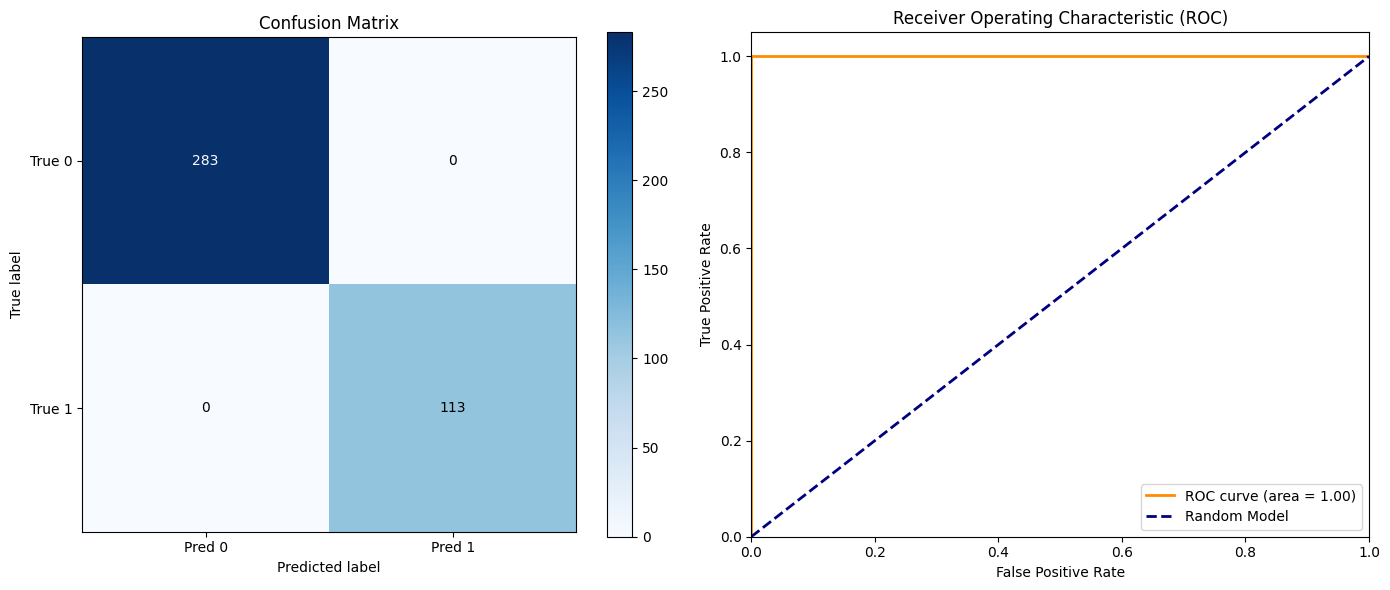

'decision_tree.pdf'

In [71]:
from sklearn.tree import DecisionTreeClassifier


plt.figure(figsize=(20, 10), dpi=300)


dt = DecisionTreeClassifier(random_state=683, max_depth=5)


dt.fit(X_train, y_train)


y_pred = dt.predict(X_test)


y_proba = dt.predict_proba(X_test)[:, 1]


generate_report(y_test, y_pred, y_proba)


from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to a Graphviz dot file
dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=X_train.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    special_characters=True,
)

# Render the graph using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Saves to a file
graph.view()  # Opens the tree in a viewer

## ResNet-BiLSTM-Attention (Sequential Effects)

Idee: DMFS model based Feature sets for training to see if the models have been learned. Feature List for models. "DMFS component-Adaptive Feature Selection".

- Time Model: duration, days and hour sin cos, throughput, is_break, is_not_weekday
- Transition Model: sequence number, process_id, resource_id
- Transformation Model: part_id, 
- Quality Model: NotImplementedError
- Resource Model: resource_id, process_id, part_id, (sequence_number)
- Resource Capacity Model: Resource_id, NOT SUFFICIENT DATA
- Process Model: process_id, part_id, resource_id, sequence_number, is_break, is_not_weekday

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from typing import List, Tuple, Dict
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report
import math

# --- Time Feature Engineering (applied to final_data) ---
# Convert start_time and end_time to datetime with UTC
final_data["start_time"] = pd.to_datetime(final_data["start_time"], utc=True)
final_data["end_time"] = pd.to_datetime(final_data["end_time"], utc=True)

# Convert datetime to Unix timestamps (in seconds)
final_data["start_time_unix"] = final_data["start_time"].view("int64") / 10**9
final_data["end_time_unix"] = final_data["end_time"].view("int64") / 10**9

# Create periodic time features
final_data["day_of_week"] = final_data["start_time"].dt.weekday
final_data["hour_of_day"] = final_data["start_time"].dt.hour

final_data["day_of_week_sin"] = np.sin(2 * np.pi * final_data["day_of_week"] / 7)
final_data["day_of_week_cos"] = np.cos(2 * np.pi * final_data["day_of_week"] / 7)
final_data["hour_of_day_sin"] = np.sin(2 * np.pi * final_data["hour_of_day"] / 24)
final_data["hour_of_day_cos"] = np.cos(2 * np.pi * final_data["hour_of_day"] / 24)


# --- Model Definition ---
class xLSTM(nn.Module):
    def __init__(
        self, input_size: int, hidden_size: int, num_layers: int, attention_heads: int
    ):
        super(xLSTM, self).__init__()

        self.lstm_layers = nn.ModuleList(
            [
                nn.LSTM(
                    input_size if i == 0 else hidden_size * 2,
                    hidden_size,
                    batch_first=True,
                    dropout=0.3,
                    bidirectional=True,
                )
                for i in range(num_layers)
            ]
        )

        self.attention_layers = nn.ModuleList(
            [
                nn.MultiheadAttention(hidden_size * 2, attention_heads)
                for _ in range(num_layers)
            ]
        )

        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.residual = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        for i, lstm_layer in enumerate(self.lstm_layers):
            x, _ = lstm_layer(x)
            x = x.transpose(0, 1)
            x, _ = self.attention_layers[i](x, x, x)
            x = x.transpose(0, 1)
            x = self.layer_norm(x)
            residual = self.residual(x)
            x = F.relu(x + residual)
        x = torch.mean(x, dim=1)
        return torch.sigmoid(self.fc(x))


# --- Dataset Definition ---
class XLSTMDataset(Dataset):
    def __init__(self, df: pd.DataFrame, sequence_length: int):
        self.sequence_length = sequence_length
        self.data = df.copy()
        self.samples = [
            self.data.iloc[i : i + sequence_length]
            for i in range(len(self.data) - sequence_length + 1)
        ]
        print("Initialized XLSTMDataset with samples:", len(self.samples))

        # Define feature and target columns (ensure these exist in your DataFrame)
        self.feature_columns = [
            "duration",
            "part_id",
            "process_type",
            "process_id",
            "resource_id",
            "sequence_number",
            "day_of_week_sin",
            "day_of_week_cos",
            "hour_of_day_sin",
            "hour_of_day_cos",
            "is_not_weekday",
            "is_break", #TODO: Add KPI Features to df and convert to right dtype. Right now I get error
        ]
        self.target_column = "is_valid"

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample_df = self.samples[idx]
        features = (
            sample_df[self.feature_columns].astype(float).values.astype(np.float32)
        )
        target = int(sample_df[self.target_column].values[0])
        return torch.tensor(features, dtype=torch.float32), torch.tensor(
            target, dtype=torch.long
        )


# --- Training and Evaluation Functions (unchanged) ---
def train_model(
    model: xLSTM,
    dataloader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 0.001,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.1,
        patience=5,
        verbose=True,
    )

    criterion = torch.nn.BCELoss()
    loss_history = []
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        scheduler.step(epoch_loss)

    return loss_history


def evaluate_model(
    model: xLSTM,
    dataloader: DataLoader,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
) -> Dict[str, float]:
    model.to(device)
    model.eval()
    correct, total = 0, 0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).squeeze(1)
            predicted = (outputs > 0.9).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_probs.extend(outputs.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    accuracy = correct / total if total > 0 else 0.0
    roc_auc = roc_auc_score(all_labels, all_probs)
    return {"accuracy": accuracy, "roc_auc": roc_auc}


def collate_fn(
    batch: List[Tuple[torch.Tensor, torch.Tensor]],
) -> Tuple[torch.Tensor, torch.Tensor]:
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels_tensor = torch.stack(labels)
    return sequences_padded, labels_tensor


def diagnose_model(
    loss_history: List[float],
    accuracy: float,
    loss_threshold: float = 0.5,
    acc_threshold: float = 0.8,
) -> None:
    if loss_history and loss_history[-1] > loss_threshold:
        print("Warning: High loss, potential underfitting.")
    if accuracy < acc_threshold:
        print("Warning: Low accuracy, model may not capture process structure well.")
    if len(loss_history) >= 5 and (loss_history[0] - loss_history[-1]) < 0.1:
        print("Warning: Loss not decreasing significantly, possible underfitting.")


def evaluate_model_with_preds(
    model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences).squeeze(1)
            probs = outputs.cpu().numpy().tolist()
            preds = (outputs > 0.9).float().cpu().numpy().tolist()
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().tolist())
    return all_labels, all_preds, all_probs


# --- Prepare Data and Train the Model ---
df_train_mod = pd.concat([X_train, y_train], axis=1)
df_test_mod = pd.concat([X_test, y_test], axis=1)

train_dataset = XLSTMDataset(df_train_mod, sequence_length=19)
test_dataset = XLSTMDataset(df_test_mod, sequence_length=19)

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

print("CUDA IS AVAILABLE?", torch.cuda.is_available())
print("Train dataset size:", len(train_dataset))
print("df_train_mod shape:", df_train_mod.shape)

model = xLSTM(
    input_size=12, hidden_size=512, num_layers=1, attention_heads=4
)  # Change input size to match your features
loss_history = train_model(model, train_loader, num_epochs=50)
metrics = evaluate_model(model, test_loader)
print("Test Accuracy:", metrics["accuracy"])
print("Test ROC AUC:", metrics["roc_auc"])

diagnose_model(loss_history, metrics["accuracy"])

all_labels, all_preds, all_probs = evaluate_model_with_preds(model, test_loader)
generate_report(all_labels, all_preds, all_probs)

torch.save(model.state_dict(), "xLSTM_model.pth")
print("Model saved.")

C:\Users\danie\AppData\Local\Temp\ipykernel_17036\1773516562.py:21: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  final_data["start_time_unix"] = final_data["start_time"].view("int64") / 10**9
C:\Users\danie\AppData\Local\Temp\ipykernel_17036\1773516562.py:22: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  final_data["end_time_unix"] = final_data["end_time"].view("int64") / 10**9
c:\Users\danie\.conda\envs\ofact\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Initialized XLSTMDataset with samples: 1565
Initialized XLSTMDataset with samples: 378
CUDA IS AVAILABLE? False
Train dataset size: 1565
df_train_mod shape: (1583, 19)


c:\Users\danie\.conda\envs\ofact\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Loss: 40.5469
Epoch 2/50, Loss: 29.8225


KeyboardInterrupt: 

Das Modell lernte nicht, als ich die Orders bereinigt habe ohne Zeitinformationen. Nun nach Integration der Zeitinfos generalisiert das Modell perfekt.

In [ ]:
import graphviz
import torchview

graphviz.set_jupyter_format("png")
model_graph = torchview.draw_graph(
    model,
    input_data=torch.randn(1, 19, 10),
    roll=True,
    graph_name="xLSTM for VVUQ",
    graph_dir="TB",
    save_graph=True,
    expand_nested=True,
)
# Schriftart und -größe global setzen
model_graph.visual_graph.graph_attr.update(fontname="Times New Roman", fontsize="14")
model_graph.visual_graph.node_attr.update(fontname="Times New Roman", fontsize="14")
model_graph.visual_graph.edge_attr.update(fontname="Times New Roman", fontsize="14")
model_graph.visual_graph

RuntimeError: Failed to run torchgraph see error message

## Diskrepanzen (ALT)

Zwischenfazit: Der DT deckt gnadenlos Schwächen in der Simulatuon auf. Er erkennt zum Beispiel, dass bestimmte Resourcen bei der Simulation vorkommen, die in der Realität nicht vorkommen. 

TODO: Mappings kongruent machen, es dürfen nur IDs in beiden vorkommen die beide Nutzen. Im realen Fall müssen diese dann exkludiert werden. Es dürfen nur Prozesse vorkommen, die auch in der Sim vorkommen.

Hier sind einige auffällige Diskrepanzen und fehlende Kategorien in den Daten:

### **1. `order_id` Diskrepanzen**
- Die `order_id`s im `is_valid == 0` Bereich sind im niedrigen Bereich (z. B. 305, 328, 353), während im `is_valid == 1` Bereich die IDs viel höher sind (z. B. 3814, 3998, 4008).
- `is_valid == 0` hat 62 eindeutige `order_id`s, während `is_valid == 1` 112 hat → Potenzielle Datenverzerrung.
- Mögliches Problem: Verschiedene `order_id`-Bereiche könnten auf eine unterschiedliche Datenherkunft oder eine nicht konsistente Zuweisung hindeuten.

---

### **2. `start_time` und `end_time` Diskrepanzen**
- `is_valid == 0`: Alle `start_time`- und `end_time`-Werte stammen aus **2025**.
- `is_valid == 1`: Werte verteilen sich auf **2022 und 2023**.
- Mögliche Ursache: Unterschiedliche Zeiträume könnten auf eine Änderung im Datenerfassungsprozess hinweisen. Sind neuere Daten möglicherweise fehlerhaft?

---

### **3. `duration` Diskrepanzen**
- `is_valid == 0`: Sehr viele niedrige `duration`-Werte, häufige Wiederholungen (z. B. 43.0, 40.0, 17.0).
- `is_valid == 1`: Deutlich mehr verschiedene Werte, mit einigen extrem hohen `duration`-Werten (bis 64088.0!).
- Mögliches Problem: Unterschiedliche Berechnung der `duration`? Unterschiedliche Prozesse?

---

### **4. `part_id` Unterschiede**
- `is_valid == 0`: `part_id`s reichen von -1 bis 8.
- `is_valid == 1`: Mehr `part_id`s (bis 14!), mit `-1` als häufigstem Wert.
- Mögliche Ursache: Einige `part_id`s fehlen im `is_valid == 0`-Bereich → Unterschiedliche Datenquellen oder Filtermechanismen.

---

### **5. `process_type` Unterschiede**
- `is_valid == 0`: Werte sind 0, 1, -1, 2.
- `is_valid == 1`: Zusätzlich `process_type == 3`.
- Mögliche Ursache: Ein neuer Prozess wurde eingeführt und ist nicht in den ungültigen (`is_valid == 0`) Daten vorhanden?

---

### **6. `process_id` Unterschiede**
- `is_valid == 0`: Meist Werte zwischen 0 und 23.
- `is_valid == 1`: Werte zwischen 0 und **73** (mehr als 50 neue `process_id`s!).
- Mögliche Ursache: Ältere Prozesse fehlen in `is_valid == 1`, oder neuere Prozesse sind nicht im `is_valid == 0`-Bereich erfasst.

---

### **7. `resource_id` Unterschiede**
- `is_valid == 0`: Werte reichen von 0 bis 8.
- `is_valid == 1`: Werte reichen von 0 bis **13**.
- Mögliche Ursache: Ressourcen wurden möglicherweise später erweitert oder unterschiedliche Datenquellen wurden kombiniert.

---

### **Zusammenfassung der Anomalien**
✅ **Häufig fehlen bestimmte IDs in einem der beiden Sets** → Möglicher Hinweis auf selektive Datenverarbeitung.  
✅ **Zeitstempel haben komplett unterschiedliche Jahre** → Mögliche Probleme mit der Datenhistorie oder fehlerhafte Datenerfassung.  
✅ **Prozess-IDs und Ressourcentypen unterscheiden sich stark** → Möglichkeit einer Änderung der Geschäftsprozesse über die Zeit.  

**Frage:**  
🔍 Ist `is_valid` eine Art Klassifikationsmerkmal für neue vs. alte Daten, oder zeigt es fehlerhafte Werte an? Das würde helfen, die Ursache der Diskrepanzen besser zu verstehen.

In [ ]:
# Product clustering based on final_data

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot
import seaborn

# Select the features for clustering
features = [
    "duration",
    "part_id",
    "process_type",
    "process_id",
    "resource_id",
    "sequence_number",
]

# Standardize the features
scaler = StandardScaler()
final_data_scaled = scaler.fit_transform(final_data[features])

# Perform PCA to reduce dimensionality
pca = PCA(n_components=2)
final_data_pca = pca.fit_transform(final_data_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
final_data["cluster"] = kmeans.fit_predict(final_data_scaled)

# Plot the clusters
plt.figure(figsize=(12, 8))
seaborn.scatterplot(
    x=final_data_pca[:, 0],
    y=final_data_pca[:, 1],
    hue=final_data["cluster"],
    palette="viridis",
)
plt.title("KMeans Clustering of Process Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()